# Abbreviations
OMG — optomiography  
ACC — accelerometer  
GYR — gyroscope  
ENC - encoders (fingers of prosthesis or gloves)  
model — model of data  

## Все импорты - сюда

In [1]:
import os, sys
import time

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
%matplotlib widget

from sklearn.linear_model import LassoLars, LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
# import lightgbm as lgb
import random
#import tensorflow as tf
#from keras import backend as K
from statistics import mean

import joblib
#import serial
from IPython.display import clear_output
from sklearn.metrics import mean_squared_error as mse

import warnings
warnings.filterwarnings('ignore')

from zipfile import ZipFile

## IO utils

In [2]:
def read_omg_csv(path_palm_data: str, 
                 n_omg_channels: int, 
                 n_acc_channels: int = 0, 
                 n_gyr_channels: int = 0, 
                 n_mag_channels: int = 0, 
                 n_enc_channels: int = 0,
                 button_ch: bool = True, 
                 sync_ch: bool = True, 
                 timestamp_ch: bool = True) -> pd.DataFrame:
    
    '''
    Reads CSV data for OMG data
    NB: data must be separated by " " separator

        Parameters:
                path_palm_data  (str): path to csv data file
                n_omg_channels  (int): Number of OMG channels
                n_acc_channels  (int): Number of Accelerometer channels, default = 0
                n_gyr_channels  (int): Number of Gyroscope channels, default = 0
                n_mag_channels  (int): Number of Magnetometer channels, default = 0
                n_enc_channels  (int): Number of Encoder channels, default = 0
                button_ch      (bool): If button channel is present, default = True
                sync_ch        (bool): If synchronization channel is present, default = True
                timestamp_ch   (bool): If timestamp channel is present, default = True

        Returns:
                df_raw (pd.DataFrame): Parsed pandas Dataframe with OMG data
    '''
    
    df_raw = pd.read_csv(path_palm_data, sep=' ', 
                         header=None, 
                         skipfooter=1, 
                         skiprows=1, 
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()
    
    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'], 
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns = columns + ['{}{}'.format(label, i) for i in range(label_count)]
        
    if button_ch:
        columns = columns + ['BUTTON']
        
    if sync_ch:
        columns = columns + ['SYNC']
        
    if timestamp_ch:
        columns = columns + ['ts']
        
    df_raw.columns = columns
    
    return df_raw

# использовать код вместо чтения из zip
# palm_file = './sprint2_pilote1_gestures.palm'
# gestures = read_omg_csv(palm_file, 
#                               n_omg_channels=50,
#                               n_acc_channels=3, 
#                               n_gyr_channels=3, 
#                               n_enc_channels=6, 
#                               n_mag_channels=0)

# print(gestures.shape)
# gestures.head()

# Data 
## Читаем трейн, тест, свободные движения в датафреймы

In [3]:
# read train from zip in data folder
with ZipFile('data/data.zip') as myzip:
    gestures_train = pd.read_csv(myzip.open('gestures_train.csv'), index_col=0)
print(gestures_train.shape)
gestures_train.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/data.zip'

In [3]:
# read test from zip in data folder
with ZipFile('data/data.zip') as myzip:
    gestures_test = pd.read_csv(myzip.open('gestures_test.csv'), index_col=0)
print(gestures_test.shape)
gestures_test.head()

(8168, 65)


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
33172,1469,11,1858,99,4,2552,29,39,2190,38,...,-3,9,12,4,1,0,0,1000,433,7587054
33173,1460,11,1857,99,6,2549,31,32,2190,41,...,-3,9,12,4,1,0,0,1000,433,7587087
33174,1471,9,1860,101,6,2554,29,35,2193,39,...,-6,10,12,4,1,0,0,1000,433,7587120
33175,1467,8,1856,98,0,2549,27,36,2190,40,...,-12,10,12,4,1,0,0,1000,433,7587153
33176,1471,6,1859,99,3,2554,28,36,2187,40,...,-19,10,12,4,1,0,0,1000,433,7587186


In [4]:
# read free movements from zip in data folder
with ZipFile('data/data.zip') as myzip:
    gestures_free = pd.read_csv(myzip.open('free_movements.csv'), index_col=0)
print(gestures_free.shape)
gestures_free.head()

(20990, 65)


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
140,1203,22,1594,123,10,2390,24,32,1848,40,...,-18,40,53,55,48,41,0,1000,0,8881644
141,1204,0,1598,136,2,2396,28,28,1847,42,...,-12,40,53,55,48,41,0,1000,0,8881677
142,1203,0,1599,132,14,2398,20,30,1851,45,...,-10,40,53,55,48,41,0,1000,0,8881710
143,1202,27,1601,115,11,2402,30,22,1858,44,...,-10,40,53,55,48,41,0,1000,0,8881743
144,1207,0,1601,109,4,2404,28,27,1857,43,...,-10,40,53,55,48,41,0,1000,0,8881776


## Задаем константы

In [4]:
OMG_CH = gestures_train.columns[:50]
ACC_CH = gestures_train.columns[50:53]
GYR_CH = gestures_train.columns[53:56]
# ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
GLOVE_CH = gestures_free.columns[56:61]  # no 'ENC5' - only 5 features
BUTTON_SYNC_TS_CH = gestures_train.columns[62:65]

TR_TIME = gestures_train.shape[0]  # time of train data
TS_TIME = gestures_test.shape[0]  # time of test data
FR_TIME = gestures_free.shape[0]  # time of free movements data

n_frame = 5  # number of time ticks in "sliding window" 

SENS = len(OMG_CH)   # sensors number
FN = len(OMG_CH) + len(ACC_CH) + len(GYR_CH)   # features number
TN = len(GLOVE_CH)   # target values number

RANDOM_STATE = 32
 
assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(GLOVE_CH)+len(BUTTON_SYNC_TS_CH) + 1 == gestures_train.shape[-1]

print(f"OMG_CH: {list(OMG_CH)}")
print(f"ACC_CH: {list(ACC_CH)}")
print(f"GYR_CH: {list(GYR_CH)}")
print(f"GLOVE_CH: {list(GLOVE_CH)}")
print(f"BUTTON_SYNC_TS_CH: {list(BUTTON_SYNC_TS_CH)}")
print(f"time: train {TR_TIME} , test {TS_TIME}, free movements {FR_TIME}")
print(f"number of:  sensors {SENS},  features {FN} , target values {TN}")

NameError: name 'gestures_train' is not defined

In [6]:
# Начальное значение для генератора случайных чисел в Python
random.seed(RANDOM_STATE)

# Начальное значение для генератора случайных чисел в Numpy
np.random.seed(RANDOM_STATE)

**Конфигурация Tenzorflow**

In [7]:
# Начальное значение для генератора случайных чисел в tensorflow 
tf.random.set_seed(RANDOM_STATE)

# Конфигурация Tenzorflow
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [8]:
def callbacks(lr):
   
    # сохранение лучшей модели
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        os.path.join('../data', 'best_model' +'.hdf5'), 
        monitor='val_mse', 
        verbose=1, 
        mode='min', 
        save_best_only=True
    )

    # остановка обучения при отсутствии улучшения заданной метрики
    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor='val_mse', 
        mode='min', 
        patience=50, # 50
        restore_best_weights=True
    )

    # снижение learning rate при отсутствии улучшения заданной метрики 
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_mse', 
        mode='min',  
        factor=0.5, 
        patience=20,  # можно 10
        verbose=1, 
        min_lr=lr/1000
    )
    
    return [checkpoint, earlystop, reduce_lr]

## Переходим к массивам

In [7]:
X_train = gestures_train[OMG_CH].values.astype(np.int16)
X_test = gestures_test[OMG_CH].values.astype(np.int16)
X_free = gestures_free[OMG_CH].values.astype(np.int16)

y_train = gestures_train[GLOVE_CH].values.astype(np.int8)
y_test = gestures_test[GLOVE_CH].values.astype(np.int8)
y_free = gestures_free[GLOVE_CH].values.astype(np.int8)

In [8]:
X_train.shape, X_test.shape, X_free.shape, y_train.shape, y_test.shape, y_free.shape

((33172, 50), (8168, 50), (20990, 50), (33172, 5), (8168, 5), (20990, 5))

# Preprocessing

Можно написать несколько альтернативных функций-сценариев препроцессинга.

Основная идея: делать весь препроцессинг одной функцией без вызова вложенных самописных функций, для уменьшения времени на реалтайм.

В последней строке присваиваем preprocessing = функция, по которой считаем в этот раз.

In [9]:
def omg_5diff_std(x, x_buf):
    # x - текущие данные omg, x_buf - буфер с предыдущей итерации n_frame + 1 тиков
    # (чтобы не делать в цикле проверку пустых начальных тиков - заполняю x_buf весь X[t=0] перед препроцессингом)
    w_buf = np.hstack((x, x_buf[:-SENS])) 
    buf = w_buf.reshape(n_frame + 1, SENS)   # смотрелка на буфер для удобства
    w = x - buf                              # первая строка заполнится нулями
    w[0] = x
    std = np.std(buf, 0) 
    w = np.hstack((w.reshape(-1), std))
    return w, w_buf

def omg_windows_diff(x, x_buf):
    w = np.hstack((x, x - x_buf[-SENS:]))
    w_buf = np.hstack((x, x_buf))[:-SENS]
    return w, w_buf

def omg_windows3_diff(x, x_buf):
    w = np.hstack((x, x_buf[:SENS*2], x - x_buf[-SENS:]))
    w_buf = np.hstack((x, x_buf))[:-SENS]
    return w, w_buf

preprocessing = omg_5diff_std

In [98]:
# SENS = 50
# x = np.array([5,6])
# x_buf = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
# a,b = preprocessing(x, x_buf)
# a,b

In [10]:
# задаем начальный буфер n_frame + 1 тиков, 
# если это запихнуть в препроцессинг - будет лишний if, который займет свое время
X_train_buf = np.hstack([X_train[0] for _ in range(n_frame + 1)])
X_train_prep = np.empty((TR_TIME, SENS * 7))

In [11]:
i = 0
while i < TR_TIME:
    X_train_prep[i], X_train_buf = preprocessing(X_train[i], X_train_buf)
    i += 1

In [12]:
# препроцессинг для трейна и теста
X_test_buf = np.hstack([X_test[0] for _ in range(n_frame + 1)])
X_test_prep = np.empty((TS_TIME, SENS * 7))

i = 0
while i < TS_TIME:
    X_test_prep[i], X_test_buf = preprocessing(X_test[i], X_test_buf)
    i += 1

X_free_buf = np.hstack([X_free[0] for _ in range(n_frame + 1)])
X_free_prep = np.empty((FR_TIME, SENS * 7))

i = 0
while i < FR_TIME:
    X_free_prep[i], X_free_buf = preprocessing(X_free[i], X_free_buf)
    i += 1

X_train_prep.shape, X_test_prep.shape, X_free_prep.shape, y_train.shape, y_test.shape, y_free.shape

((33172, 350), (8168, 350), (20990, 350), (33172, 5), (8168, 5), (20990, 5))

# Modeling

Можно построить несколько разных конфигураций моделей и вызывать разные.

ИМХО: лучше сохранять каждую значимую модель в отдельном файле, чтобы сохранить результаты и быстро переключаться между ними для сравнения.

In [13]:
model = RandomForestRegressor(n_estimators=200, max_features='log2', max_depth=25, random_state=RANDOM_STATE)
# model = LinearRegression()

model.fit(X_train_prep, y_train)

RandomForestRegressor(max_depth=25, max_features='log2', n_estimators=200,
                      random_state=32)

## Сохраняем / читаем сохраненную модель

In [21]:
#joblib.dump(model, 'data/RF-wind3.sav')

['data/RF-wind3.sav']

In [22]:
#model = joblib.load('data/RF-wind3.sav')

## Prediction

In [14]:
# сразу делаем предикт и датафреймы для построения графиков
y_train_pred = model.predict(X_train_prep)
df_y_train = pd.DataFrame(y_train, columns=GLOVE_CH, index=gestures_train['ts'])
df_y_train_pred = pd.DataFrame(y_train_pred, columns=GLOVE_CH, index=gestures_train['ts'])

y_test_pred = model.predict(X_test_prep)
df_y_test = pd.DataFrame(y_test, columns=GLOVE_CH, index=gestures_test['ts'])
df_y_test_pred = pd.DataFrame(y_test_pred, columns=GLOVE_CH, index=gestures_test['ts'])

y_free_pred = model.predict(X_free_prep)
df_y_free = pd.DataFrame(y_free, columns=GLOVE_CH, index=gestures_free['ts'])
df_y_free_pred = pd.DataFrame(y_free_pred, columns=GLOVE_CH, index=gestures_free['ts'])

## Metrics

In [15]:
metrics_train = {col : mse(df_y_train[col], df_y_train_pred[col]) for col in GLOVE_CH}
metrics_test = {col : mse(df_y_test[col], df_y_test_pred[col]) for col in GLOVE_CH}
metrics_free = {col : mse(df_y_free[col], df_y_free_pred[col]) for col in GLOVE_CH}

metrics_train = pd.Series(metrics_train)
metrics_test = pd.Series(metrics_test)
metrics_free = pd.Series(metrics_free)

print('Train')
display(metrics_train)
print('Test')
display(metrics_test)
print('Free movements')
display(metrics_free)

Train


ENC0     8.290462
ENC1     6.805693
ENC2     8.111948
ENC3    15.499649
ENC4    36.985592
dtype: float64

Test


ENC0     70.355442
ENC1     79.184217
ENC2     75.414349
ENC3    262.492896
ENC4    393.706115
dtype: float64

Free movements


ENC0    731.116937
ENC1    519.078424
ENC2    655.380428
ENC3    994.440591
ENC4    650.918802
dtype: float64

## Визуализация

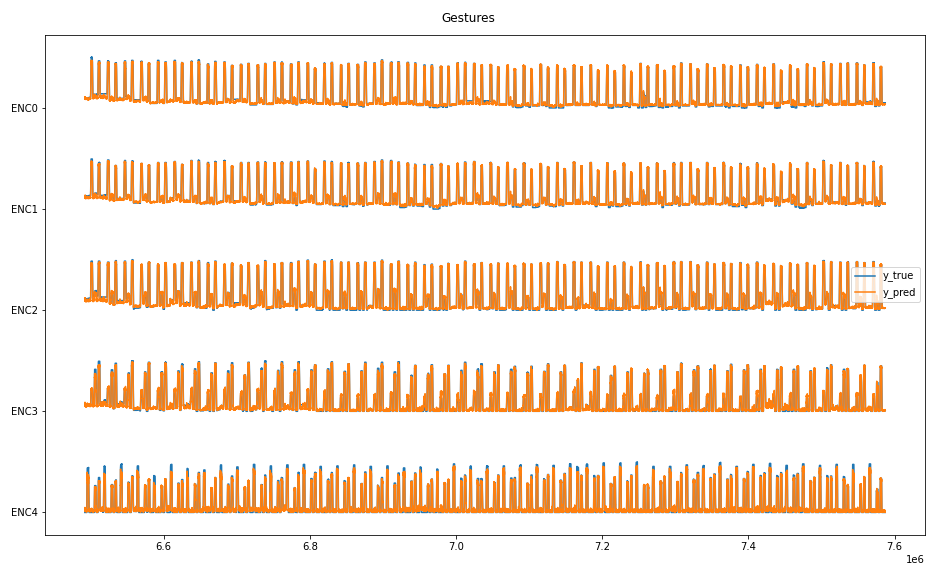

In [45]:
# train
fig, axes = plt.subplots(1, 1, figsize=(13, 8))

plt.cla()
plt.sca(axes)
lines = []
labels = []
yticks = -np.arange(len(GLOVE_CH)) * 200
start = int(TR_TIME*5/6)

p = plt.plot(gestures_train['ts'].values, y_train + yticks, c='C0')
lines += [p[0]]
labels += ['y_true']

p = plt.plot(gestures_train['ts'].values, y_train_pred + yticks, c='C1', linestyle='-')
lines += [p[0]]
labels += ['y_pred']

plt.yticks(yticks, GLOVE_CH)
plt.legend(lines, labels)
plt.suptitle(f'Gestures')
plt.tight_layout()

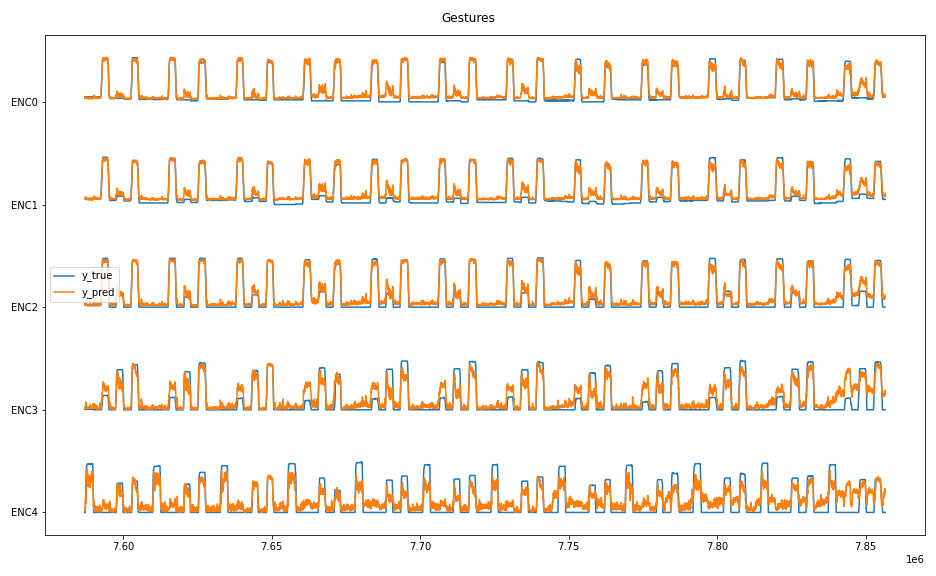

In [46]:
# test
fig, axes = plt.subplots(1, 1, figsize=(13, 8))

plt.cla()
plt.sca(axes)
lines = []
labels = []
yticks = -np.arange(len(GLOVE_CH)) * 200

p = plt.plot(gestures_test['ts'].values, y_test + yticks, c='C0')
lines += [p[0]]
labels += ['y_true']

p = plt.plot(gestures_test['ts'].values, y_test_pred + yticks, c='C1', linestyle='-')
lines += [p[0]]
labels += ['y_pred']

plt.yticks(yticks, GLOVE_CH)
plt.legend(lines, labels)
plt.suptitle(f'Gestures')
plt.tight_layout()

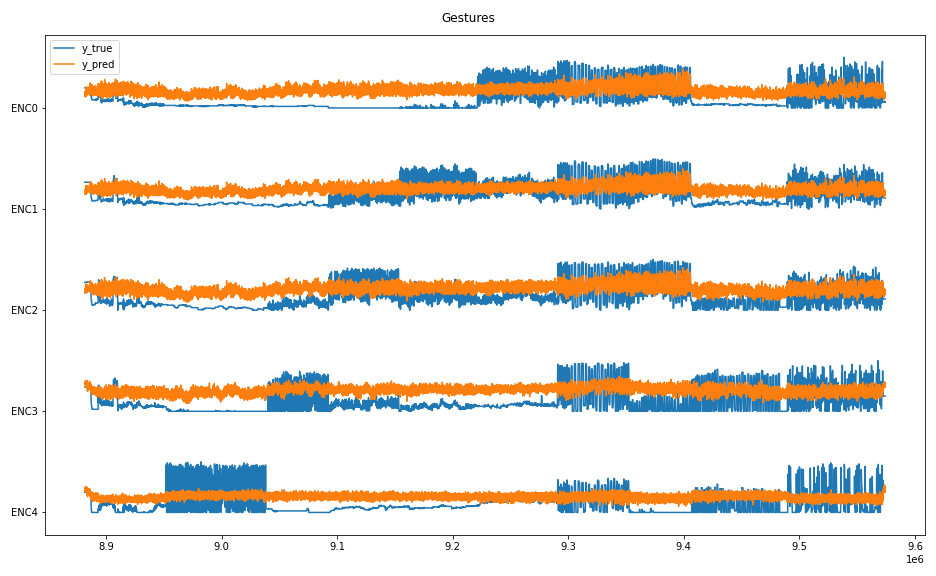

In [47]:
# free movements
fig, axes = plt.subplots(1, 1, figsize=(13, 8))

plt.cla()
plt.sca(axes)
lines = []
labels = []
yticks = -np.arange(len(GLOVE_CH)) * 200

p = plt.plot(gestures_free['ts'].values, y_free + yticks, c='C0')
lines += [p[0]]
labels += ['y_true']

p = plt.plot(gestures_free['ts'].values, y_free_pred + yticks, c='C1', linestyle='-')
lines += [p[0]]
labels += ['y_pred']

plt.yticks(yticks, GLOVE_CH)
plt.legend(lines, labels)
plt.suptitle(f'Gestures')
plt.tight_layout()

# Real-time inference

## Inference Utils: Put your code here

In [151]:
def preprocessing(x, x_buf):
    # x - текущие данные omg, x_buf - буфер с предыдущей итерации 
    # делаем скользящее окно на n_frame тиков 
    # (не хочу в цикле делать проверку пустых начальных тиков - нужно продублировать X[t=0] в начале вызова данных) 
    w = np.hstack((x_buf, x))[SENS:]
    return w

def inference(x):
    y = model.predict([x])[0] 
    return y

def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x  #*0.1 + prev*0.9 # Holt-Winters filter
    return y

def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y

### Offline (dataset)

In [152]:
TIME_INT = slice(TS_TIME-TS_TIME, TS_TIME)

df_sim = gestures_test[TIME_INT].copy()
print(df_sim.shape)

(8168, 65)


In [153]:
TIMEOUT = 0.033
DEBUG = True

# начальный буфер n_frame тиков
sample_preprocessed = np.hstack([df_sim.values[0, :SENS] for _ in range(n_frame)]) 
    
i = 0
ts_old = time.time()
ts_diff = 0

y_predicted = np.zeros(6)
y_previous = None
y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
    'ts_diff':[],
}
while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample, sample_preprocessed)
    # [/Data preprocessing]
    
    # [Inference]
    # classic prediction
    y_predicted         = inference(sample_preprocessed)
    # refeed prediction
    # y_predicted         = inference(np.r_[sample_preprocessed, y_predicted])
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    y_dct['ts_diff'].append(ts_diff)
    #assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    
    ts_old = ts_start
    i += 1 

SAMPLE SIZE: 65, OMG: 50, ACC: 6, ENCODERS: 6
BUTTON: 1000, SYNC: 539, TS: 7856565
[13 19 19 22 29]


In [154]:
mean(y_dct['ts_diff'])

0.01540095837062533

In [168]:
df_pred = pd.DataFrame(y_dct['y_commands'], columns=GLOVE_CH, index=gestures_test['ts'][TIME_INT])

In [169]:
# метрики оффлайн
metrics_test = {col : mse(df_y_test[col][TIME_INT], df_pred[col]) for col in GLOVE_CH}

metrics_test = pd.Series(metrics_test)

print('Test')
display(metrics_test)

Test


ENC0     45.175930
ENC1     51.664300
ENC2     46.057542
ENC3    188.657199
ENC4    332.637610
dtype: float64

In [157]:
# метрики предикта на X_test_pred
metrics_test = {col : mse(df_y_test[col][TIME_INT], df_y_test_pred[col][TIME_INT]) for col in GLOVE_CH}

metrics_test = pd.Series(metrics_test)

print('Test')
display(metrics_test)

Test


ENC0     45.112565
ENC1     51.655236
ENC2     45.986986
ENC3    188.489157
ENC4    332.628234
dtype: float64

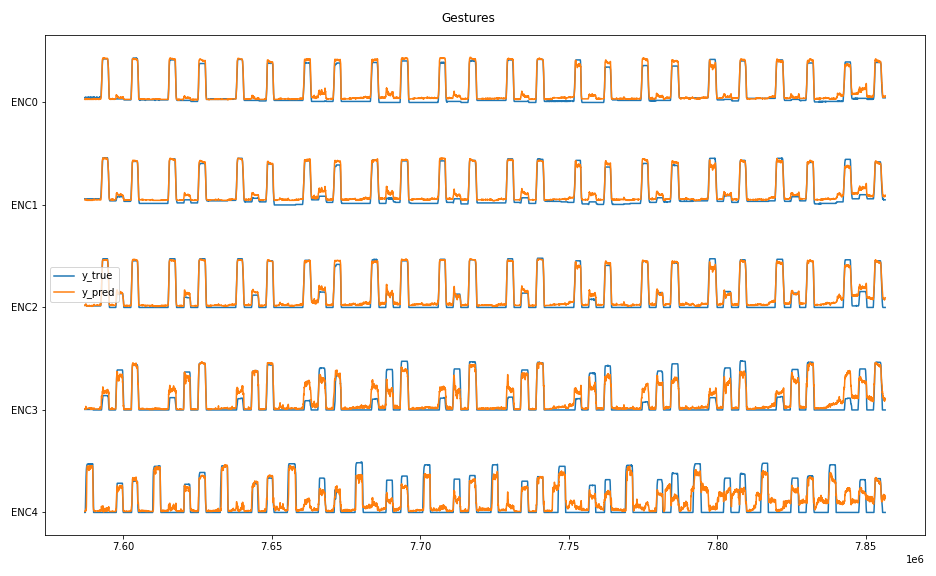

In [158]:
# test
fig, axes = plt.subplots(1, 1, figsize=(13, 8))

plt.cla()
plt.sca(axes)
lines = []
labels = []
yticks = -np.arange(len(GLOVE_CH)) * 200

p = plt.plot(gestures_test['ts'][TIME_INT].values, y_test[TIME_INT] + yticks, c='C0')
lines += [p[0]]
labels += ['y_true']

p = plt.plot(gestures_test['ts'][TIME_INT].values, df_pred + yticks, c='C1', linestyle='-')
lines += [p[0]]
labels += ['y_pred']

plt.yticks(yticks, GLOVE_CH)
plt.legend(lines, labels)
plt.suptitle(f'Gestures')
plt.tight_layout()

# Real-time inference - optimized a bit

In [16]:
def preprocessing(x, x_buf):
    # x - текущие данные omg, x_buf - буфер с предыдущей итерации n_frame + 1 тиков
    # (чтобы не делать в цикле проверку пустых начальных тиков - заполняю x_buf весь X[t=0] перед препроцессингом)
    w_buf = np.hstack((x, x_buf[:-SENS])) 
    buf = w_buf.reshape(n_frame + 1, SENS)   # смотрелка на буфер для удобства
    w = x - buf                              # первая строка заполнится нулями
    w[0] = x
    std = np.std(buf, 0) 
    w = np.hstack((w.reshape(-1), std))
    return w, w_buf

def inference(x):
    y = model.predict([x])[0] 
    return y

def postprocessing(x, prev, prev2):
    if prev2 is None:
        y = x 
    else:
        y = x * 0.1 + (2 * prev - prev2) * 0.9
    return y

def commands(x):
    y = np.clip(x, 0, 100).astype(int)
    return y

In [17]:
TIME_INT = slice(TS_TIME-TS_TIME, TS_TIME)

df_sim = gestures_test[TIME_INT].values
print(df_sim.shape)

(8168, 65)


In [18]:
TIMEOUT = 0.033
DEBUG = True

i = 0

# начальный буфер n_frame + 1 тиков
sample_buf = np.hstack([df_sim[0, :SENS] for _ in range(n_frame + 1)])

ts_old = time.time()
ts_diff = 0

y_predicted = np.zeros(6)
y_postprocessed = y_previous = None
y_dct_i = {'columns': ['omg_sample', 'enc_sample', 'sample_preprocessed', 'y_predicted', 'y_postprocessed', 'y_commands', 'ts_diff']}

while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < df_sim.shape[0]:
            sample = df_sim[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed, sample_buf = preprocessing(omg_sample, sample_buf)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed, y_previous     = postprocessing(y_predicted, y_postprocessed, y_previous), y_postprocessed
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    logs = ['' for i in range(7)]
    logs[0] = omg_sample
    logs[1] = enc_sample
    logs[2] = sample_preprocessed
    logs[3] = y_predicted
    logs[4] = y_postprocessed
    logs[5] = y_commands
    # [/Data logging]

    # y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        # print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        # print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        # print(y_commands)
    
    ts_diff = time.time() - ts_start
    logs[6] = ts_diff
    y_dct_i[i] = logs
        
    #assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'

    ts_old = ts_start
    i += 1 

In [19]:
mean([y_dct_i[i][6] for i in range(TIME_INT.stop - TIME_INT.start)])

0.013188304676948868

In [20]:
df_pred = [y_dct_i[i][3] for i in range(TIME_INT.stop - TIME_INT.start)]
df_pred = pd.DataFrame(df_pred, columns=GLOVE_CH, index=gestures_test['ts'][TIME_INT])

In [21]:
# метрики оффлайн opt
metrics_test = {col : mse(df_y_test[col][TIME_INT], df_pred[col]) for col in GLOVE_CH}

metrics_test = pd.Series(metrics_test)

print('Test')
display(metrics_test)

Test


ENC0     70.355442
ENC1     79.184217
ENC2     75.414349
ENC3    262.492896
ENC4    393.706115
dtype: float64

ENC0     70.355442
ENC1     79.184217
ENC2     75.414349
ENC3    262.492896
ENC4    393.706115
dtype: float64

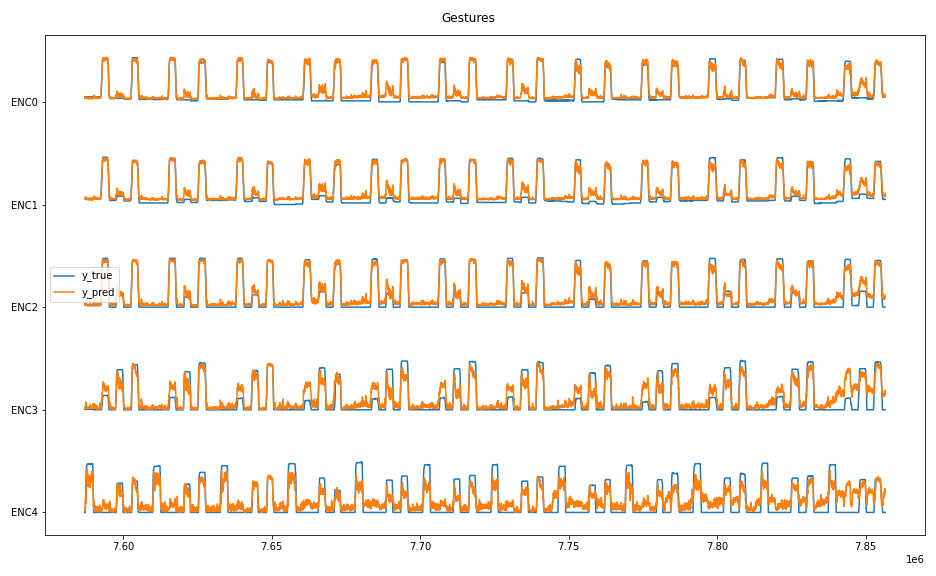

In [22]:
# test
fig, axes = plt.subplots(1, 1, figsize=(13, 8))

plt.cla()
plt.sca(axes)
lines = []
labels = []
yticks = -np.arange(len(GLOVE_CH)) * 200

p = plt.plot(gestures_test['ts'][TIME_INT].values, y_test[TIME_INT] + yticks, c='C0')
lines += [p[0]]
labels += ['y_true']

p = plt.plot(gestures_test['ts'][TIME_INT].values, df_pred + yticks, c='C1', linestyle='-')
lines += [p[0]]
labels += ['y_pred']

plt.yticks(yticks, GLOVE_CH)
plt.legend(lines, labels)
plt.suptitle(f'Gestures')
plt.tight_layout()

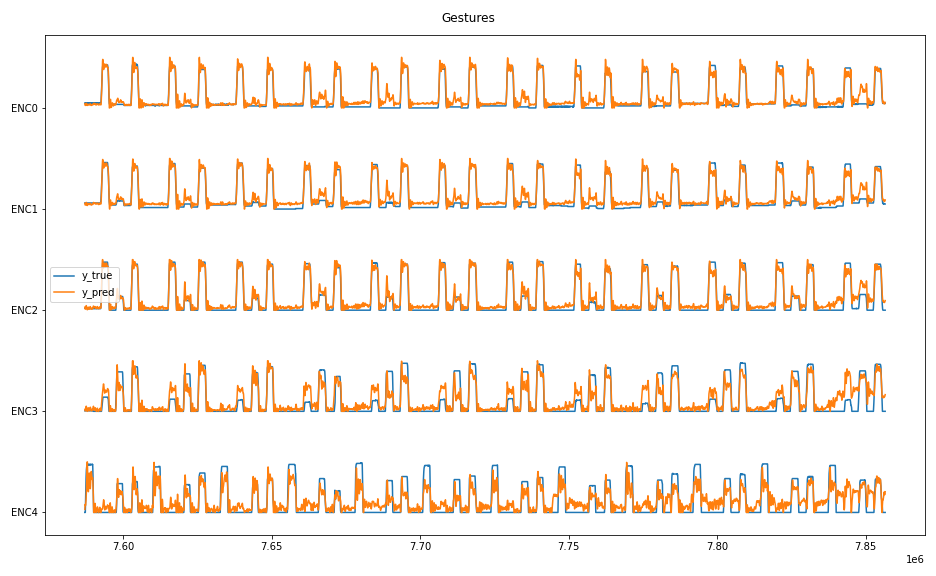

In [24]:
# test
fig, axes = plt.subplots(1, 1, figsize=(13, 8))

plt.cla()
plt.sca(axes)
lines = []
labels = []
yticks = -np.arange(len(GLOVE_CH)) * 200

p = plt.plot(gestures_test['ts'][TIME_INT].values, y_test[TIME_INT] + yticks, c='C0')
lines += [p[0]]
labels += ['y_true']

p = plt.plot(gestures_test['ts'][TIME_INT].values, [y_dct_i[i][5] for i in range(TIME_INT.stop - TIME_INT.start)] + yticks, c='C1', linestyle='-')
lines += [p[0]]
labels += ['y_pred']

plt.yticks(yticks, GLOVE_CH)
plt.legend(lines, labels)
plt.suptitle(f'Gestures')
plt.tight_layout()

## Online (prosthesis or virtual hand)

In [28]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

In [29]:
TIMEOUT = 0.033
DEBUG = True

ser = None
# ser_port = None
# ser_port = '/dev/ttyACM0'
ser_port = '/dev/cu.usbmodem3498365F31351'

if ser_port is not None:
    ser = serial.Serial(port=ser_port, timeout=2*TIMEOUT)
    ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
    ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
    ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check

    # flush buffers
    ser.reset_input_buffer()
    ser.read()
    
    i = 0;
    while(ser.in_waiting):
        print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
        ser.read_all()
        time.sleep(0.005)
        i+=1;
    ser.readline()
    ser.readline()
    
i = 0

# начальный буфер n_frame + 1 тиков
sample_buf = np.hstack([df_sim[0, :SENS] for _ in range(n_frame + 1)])

ts_old = time.time()
ts_diff = 0;
sample_buf = y_postprocessed = y_previous = None

while True:    
    
    # [Data reading]
    s = ser.readline()
    ts_start = time.time()
    
    try:
        sample = np.array(s.decode('UTF-8')\
                           .replace('\r\n', "")\
                           .split(' ')
                         ).astype(int)
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
    
    if not sample_buf:
        sample_buf = np.hstack([omg_sample for _ in range(n_frame + 1)])
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed, sample_buf = preprocessing(omg_sample, sample_buf)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed, y_previous     = postprocessing(y_predicted, y_postprocessed, y_previous), y_postprocessed
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
    # [/Commands sending]
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
        print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
        print('INPUT:\n', s)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
        print(pack)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 

AttributeError: module 'serial' has no attribute 'Serial'